In [138]:
import os, time
import numpy as np
import fitsio
import matplotlib.pyplot as plt
from astropy.table import Table

### Check the masking

In [130]:
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # LSLGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
)

# Bits in the "brightblob" bitmask
IN_BLOB = dict(
    BRIGHT = 0x1,
    MEDIUM = 0x2,
    CLUSTER = 0x4,
    GALAXY = 0x8,
)

In [146]:
gaia = Table.read('check-gaia-decam.fits')
gaia

BRICKNAME,BRICK_PRIMARY,BRIGHTBLOB,MASKBITS,TYPE,RA,DEC,BX,BY,REF_CAT,REF_ID,GAIA_PHOT_G_MEAN_MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z
bytes8,bool,int16,int16,bytes4,float64,float64,float32,float32,bytes2,int64,float32,float32,float32,float32,float32,float32,float32
1350p335,True,0,1,PSF,134.92843243478697,33.37501767093805,2620.7034,82.46497,,0,0.0,0.2897492,0.4860415,0.63876486,1476.666,474.39328,94.09064
1350p335,True,0,0,PSF,134.92885028772062,33.375601887514954,2615.9033,90.489136,,0,0.0,0.21821792,0.52454865,0.6644881,1488.9829,474.3993,94.199844
1350p335,True,0,0,PSF,135.1316878222775,33.375756713164314,288.45737,93.292946,G2,713287247735953280,16.93665,98.71353,188.55865,248.89647,142.83481,56.931503,34.93273
1350p335,True,2,2064,PSF,135.07846141248947,33.377421812643824,899.2179,115.55612,G2,713288141089101696,15.411125,528.58527,719.9368,753.5154,31.101421,16.9854,8.076427
1350p335,True,2,2048,PSF,135.07897199625378,33.3755246475573,893.33954,89.4925,G2,713288141089102080,18.129564,28.35335,64.81519,94.44299,385.91187,127.05324,55.148693
1350p335,True,0,0,PSF,134.87904349417235,33.37581612280609,3187.4058,93.959915,G2,713290374472102912,17.24975,35.571926,128.53609,323.0675,332.55164,80.33479,28.643694
1350p335,True,0,0,PSF,135.0121329930715,33.3755358095466,1660.2806,89.31043,,0,0.0,0.1415862,0.25523955,0.5262368,1512.96,474.5875,66.08998
1350p335,True,0,0,PSF,134.95280071585944,33.3752986402654,2341.0872,86.166214,G2,713290198376942336,19.616259,8.670692,15.927548,22.119194,561.4854,130.46448,46.514046
1350p335,True,0,0,REX,134.88782341398388,33.37582776462404,3086.661,94.007126,,0,0.0,0.06783101,0.31473637,1.9846932,1303.8052,403.57907,76.660934


#### All DUPs should be in an LSLGA blob.

In [132]:
idup = gaia['TYPE'] == 'DUP'
assert(np.all(gaia[idup]['MASKBITS'] & MASKBITS['GALAXY'] != 0))
assert(np.all(gaia[idup]['FLUX_G'] == 0))
for band in ('G', 'R', 'Z'):
    assert(np.all(gaia[idup]['FLUX_{}'.format(band)] == 0))
    assert(np.all(gaia[idup]['FLUX_IVAR_{}'.format(band)] == 0))
gaia[idup]

BRICKNAME,BRICK_PRIMARY,BRIGHTBLOB,MASKBITS,TYPE,RA,DEC,REF_CAT,REF_ID,GAIA_PHOT_G_MEAN_MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z
bytes8,bool,int16,int16,bytes4,float64,float64,bytes2,int64,float32,float32,float32,float32,float32,float32,float32
,True,0,4096,DUP,135.09500547158228,33.005760519695784,G2,713261542354836096,18.46803,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.45765263482355,32.873589504953294,G2,712500306647728000,19.099424,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.352871281382,31.67103075440068,G2,711814486270364544,18.603287,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.28261554578248,31.764911163291007,G2,712003739709448448,18.65861,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.185988504526,33.201000037925326,G2,713273190306158592,18.707582,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,134.94393602118268,33.20262044344028,G2,713279207557185792,18.004442,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.78803875710074,34.094634915161514,G2,713428874282379776,18.243408,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.21372423765413,34.48659323742098,G2,713689256674891136,19.5117,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.60111117056383,32.953389511233155,G2,712523602550330752,18.446753,0.0,0.0,0.0,0.0,0.0,0.0


#### 1) Find all bright Gaia stars.
#### 2) Make sure the magnitude limits are correct.
#### 3) Make sure the masking behavior around them is correct.

1606 2364
2360
NPRIMARY 0
BRIGHT 4
SATUR_G 0
SATUR_R 0
SATUR_Z 0
ALLMASK_G 0
ALLMASK_R 0
ALLMASK_Z 0
WISEM1 1
WISEM2 1
BAILOUT 0
MEDIUM 4
GALAXY 0
CLUSTER 0


BRICKNAME,BRICK_PRIMARY,BRIGHTBLOB,MASKBITS,TYPE,RA,DEC,REF_CAT,REF_ID,GAIA_PHOT_G_MEAN_MAG
bytes8,bool,int16,int16,bytes4,float64,float64,bytes2,int64,float32
1324p337,True,0,2050,PSF,132.45045951922924,33.786983496163316,G2,716188888984974080,18.107346
1337p330,True,0,2050,PSF,133.71063212320345,32.94409161567506,G2,713119293037908736,19.135618
1373p330,True,0,2050,PSF,137.1740008594221,32.878714176885104,G2,712378668877879296,19.322224
1400p342,True,0,2818,PSF,140.1327262248013,34.31740242059666,G2,702340303811110656,21.172768


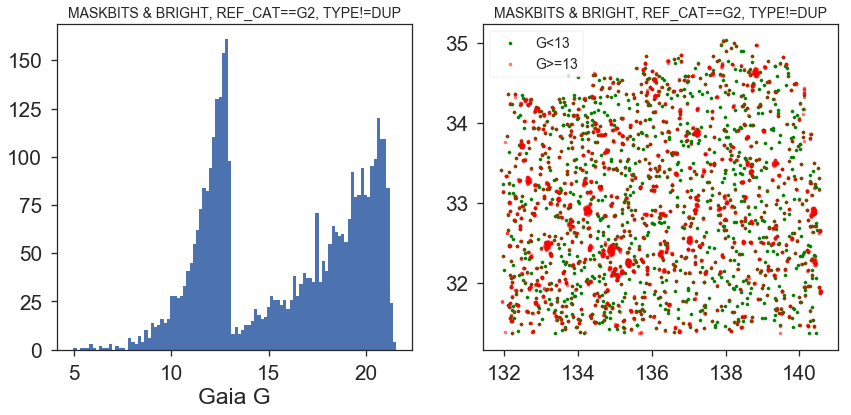

In [126]:
ibright = np.where(((gaia['MASKBITS'] & MASKBITS['BRIGHT']) != 0) * (gaia['REF_CAT'] == 'G2') * (gaia['TYPE'] != 'DUP'))[0]
#bb = (gaia['BRIGHTBLOB'][ibright] & IN_BLOB['BRIGHT'] != 0) == False
#gaia[ibright][bb]
#gaia[ibright]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
_ = ax1.hist(gaia[ibright]['GAIA_PHOT_G_MEAN_MAG'], bins=100)
ax1.set_xlabel('Gaia G')
ax1.set_title('MASKBITS & BRIGHT, REF_CAT==G2, TYPE!=DUP', fontsize=14)

isb = np.where(gaia[ibright]['GAIA_PHOT_G_MEAN_MAG'] < 13.0)[0]
isf = np.where(gaia[ibright]['GAIA_PHOT_G_MEAN_MAG'] >= 13.0)[0]
print(len(isb), len(isf))

ax2.scatter(gaia['RA'][ibright][isb], gaia['DEC'][ibright][isb], s=10, color='green', label='G<13')
ax2.scatter(gaia['RA'][ibright][isf], gaia['DEC'][ibright][isf], s=10, color='red', alpha=0.5, label='G>=13')
ax2.legend(fontsize=14, frameon=True)
ax2.set_title('MASKBITS & BRIGHT, REF_CAT==G2, TYPE!=DUP', fontsize=14)

#ax.set_xlim(136.8, 137.2)
#ax.set_ylim(32.4, 32.8)

print(np.sum(gaia['BRIGHTBLOB'][ibright][isf] & IN_BLOB['BRIGHT'] != 0))
check = np.where(gaia['BRIGHTBLOB'][ibright][isf] & IN_BLOB['BRIGHT'] == 0)[0] # no bright targeting bit set

for key in MASKBITS.keys():
    print(key, np.sum(gaia['MASKBITS'][ibright][isf][check] & MASKBITS[key] != 0))

gaia[ibright][isf][check]

#### Make sure the MASKBITS values are set correctly.

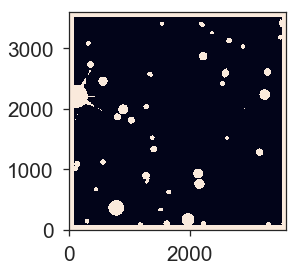

In [156]:
mask = fitsio.read('decam/coadd/132/1325p325/legacysurvey-1325p325-maskbits.fits.fz')
#print(mask.max())
c = plt.imshow(mask > 0, origin='lower')
#plt.colorbar(c)

In [152]:
ww = gaia['BRICKNAME'] == '1325p325'
eq = []
for obj in gaia[ww]:
    eq.append(mask[int(obj['BY']), int(obj['BX'])] == obj['MASKBITS'])
assert(np.all(eq))